# Part 1: Prediction with Hardcoded Model

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import time

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
trainX = torch.tensor(train.loc[:, train.columns != 'DTH_CUM_CP'].values, dtype = torch.float64)
trainY = torch.tensor(train.loc[:, train.columns == "DTH_CUM_CP"].values, dtype = torch.float64)
testX = torch.tensor(test.loc[:, test.columns != 'DTH_CUM_CP'].values, dtype = torch.float64)
testY = torch.tensor(test.loc[:, test.columns == "DTH_CUM_CP"].values, dtype = torch.float64)

In [4]:
coef = torch.tensor([
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040], # POS_50_59_CP
        [0.0300], # POS_60_69_CP
        [0.0300],
        [0.0300],
        [0.0300]
], dtype=testX.dtype)

In [5]:
if torch.cuda.is_available():
    trainX = trainX.to("cuda")
    trainY = trainY.to("cuda")
    testX = testX.to("cuda")
    testY = testY.to("cuda")
    coef = coef.to("cuda")
    
pred = (testX[0] @ coef)[0]
print("Predictions for first row: " + str(pred.item()))


Predictions for first row: 9.844


# Part 2: R^2 Score

In [6]:
def r2_score(testY, predictedY):
    meantesty = testY.mean().item()
    #SStot
    dif = testY - meantesty
    dif_2 = dif ** 2
    SStot = dif_2.sum().item()
    #SSreg
    difssreg = testY - predictedY
    dif_2ssreg = difssreg ** 2
    SSreg = dif_2ssreg.sum().item()
    
    improvement = SStot - SSreg
    R_2 = improvement/SStot
    return R_2


In [7]:
predictedY = testX @ coef
print("R-Squared Score: " + str(r2_score(testY, predictedY)))


R-Squared Score: 0.41103503288417204


# Part 3: Optimization

In [8]:
x = torch.tensor(0.0, requires_grad=True)
y = x**2 - 8*x + 19

optimizer = torch.optim.SGD([x], lr=0.1)
x_values = []
y_values = []

for i in range(30):
    optimizer.zero_grad()
    y = x**2 - 8*x + 19
    y.backward()
    optimizer.step()
    print(x, y)
    x_values.append(x.item())
    y_values.append(y.item())


optimized_x = x.item()

tensor(0.8000, requires_grad=True) tensor(19., grad_fn=<AddBackward0>)
tensor(1.4400, requires_grad=True) tensor(13.2400, grad_fn=<AddBackward0>)
tensor(1.9520, requires_grad=True) tensor(9.5536, grad_fn=<AddBackward0>)
tensor(2.3616, requires_grad=True) tensor(7.1943, grad_fn=<AddBackward0>)
tensor(2.6893, requires_grad=True) tensor(5.6844, grad_fn=<AddBackward0>)
tensor(2.9514, requires_grad=True) tensor(4.7180, grad_fn=<AddBackward0>)
tensor(3.1611, requires_grad=True) tensor(4.0995, grad_fn=<AddBackward0>)
tensor(3.3289, requires_grad=True) tensor(3.7037, grad_fn=<AddBackward0>)
tensor(3.4631, requires_grad=True) tensor(3.4504, grad_fn=<AddBackward0>)
tensor(3.5705, requires_grad=True) tensor(3.2882, grad_fn=<AddBackward0>)
tensor(3.6564, requires_grad=True) tensor(3.1845, grad_fn=<AddBackward0>)
tensor(3.7251, requires_grad=True) tensor(3.1181, grad_fn=<AddBackward0>)
tensor(3.7801, requires_grad=True) tensor(3.0756, grad_fn=<AddBackward0>)
tensor(3.8241, requires_grad=True) tenso

In [9]:
print("Optimized x: " + str(optimized_x))

Optimized x: 3.9950480461120605


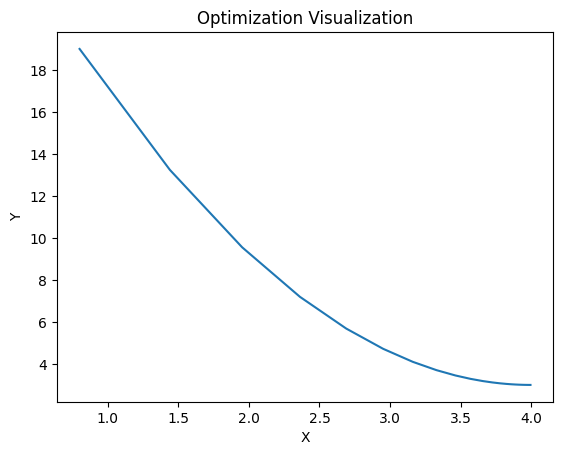

In [10]:
plt.plot(x_values,y_values)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Optimization Visualization")
plt.show()

# Part 4: Linear Regression

In [11]:
train_data = TensorDataset(trainX, trainY)
data_loader = DataLoader(train_data, shuffle = True, batch_size = 30)

In [12]:
input = trainX.shape[1]
output = trainY.shape[1]
loss_fn = torch.nn.MSELoss()
model = torch.nn.Linear(input, output, dtype = torch.float64)
optimizer = torch.optim.SGD([model.weight, model.bias], lr=0.000001)

start = time.time()
for epoch in range(100):
    for x, y in data_loader:
        prediction = model(x)
        loss = loss_fn(y, prediction)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
duration = time.time() - start

coef = model.weight.clone().detach().unsqueeze(-1)
predictions = testX @ coef
print("Training Time: "+ str(duration))
print("R-Squared: " + str(r2_score(testY, predictions)))
    

Training Time: 1.696190357208252
R-Squared: 0.5570555750575804


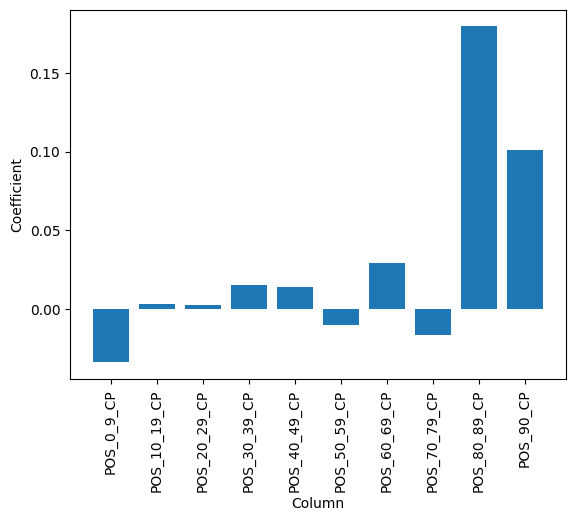

In [13]:
columns = train.columns.to_list()[:-1]
weights = model.weight.tolist()[0]
plt.bar(columns, weights)
plt.xticks(rotation = 90)
plt.xlabel("Column")
plt.ylabel("Coefficient")
plt.show()